<p align="center">
  <br/>
    <img alt="ScaleDP" src="https://raw.githubusercontent.com/StabRise/ScaleDP/refs/heads/master/images/scaledp.webp" width="376" style="max-width: 100%;">
  <br/>
</p>

<p align="center">
    <a target="_blank" href="https://colab.research.google.com/github/StabRise/scaledp-tutorials/blob/master/2.Ocr.ipynb">
        <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
    </a>
    <a href="https://github.com/stabrise/scaledp/" alt="GitHub"><img src="https://img.shields.io/static/v1?label=GitHub&message=ScaleDP&color=blue&logo=github" /></a>
    <a href="https://pypi.org/project/scaledp/" alt="Package on PyPI"><img src="https://img.shields.io/pypi/v/scaledp.svg" /></a>    
    <a href="https://github.com/stabrise/scaledp/blob/main/LICENSE"><img alt="GitHub" src="https://img.shields.io/github/license/stabrise/scaledp.svg?color=blue"></a>
    <a href="https://stabrise.com"><img alt="StabRise" src="https://img.shields.io/badge/by-StabRise-orange.svg?style=flat&colorA=E1523D&colorB=007D8A"></a>
</p>

## Installation

In [1]:
%%bash
[[ ! "${COLAB_RELEASE_TAG}" ]] && exit
sudo apt install tesseract-ocr

In [ ]:
!pip install scaledp[ocr]

## Start Spark Session with ScaleDP

In [2]:
from scaledp import *

spark = ScaleDPSession()
spark


## Read image from the file to the DataFrame

Image#:,0
Path:,receipt.jpg
Size:,960 x 1280 px
Resolution:,0 dpi

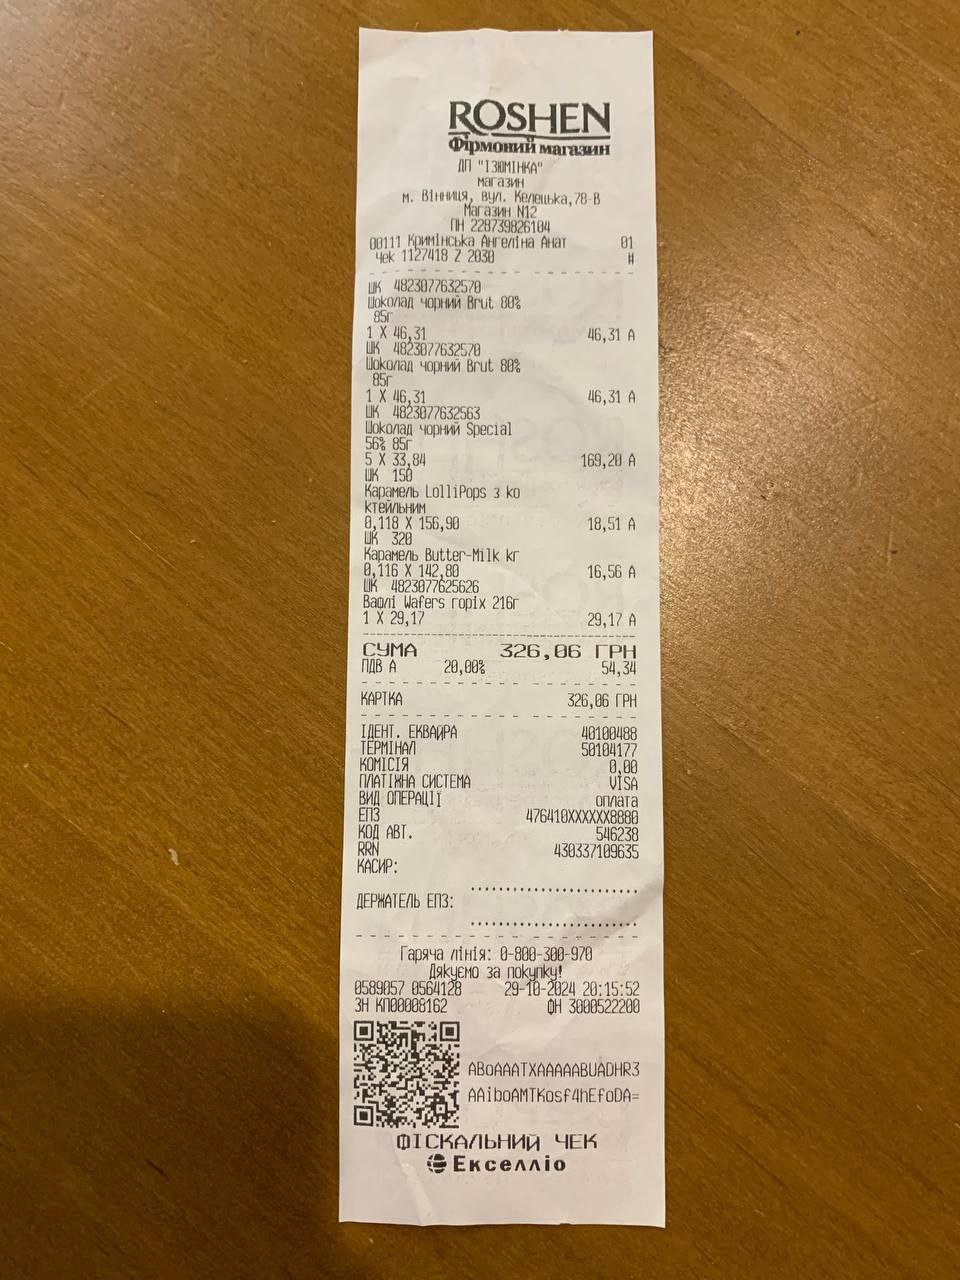

In [3]:
image_example = files('resources/images/receipt.jpg')

df = spark.read.format("binaryFile") \
    .load(image_example)

df.show_image()

## Define Schema of data

In [4]:
from pydantic import BaseModel, Field
import json

class ReceiptItem(BaseModel):
    """Purchased items."""
    name: str
    quantity: float
    price_per_unit: float
    hko: str = Field(description="ШКО код")
    price: float


class ReceiptSchema(BaseModel):
    """Receipt."""
    company_name: str
    shop_name: str
    address: str
    tax_id: str
    transaction_date: str = Field(description="Date of the transaction")
    total_amount: float
    items: list[ReceiptItem]

## Define Pipeline

Matplotlib is building the font cache; this may take a moment.


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/Users/olchikd/Library/Application Support/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


best.pt:   0%|          | 0.00/6.03M [00:00<?, ?B/s]

[Stage 1:>                                                          (0 + 1) / 1]
0: 640x480 1 receipt, 269.0ms
Speed: 17.7ms preprocess, 269.0ms inference, 22.3ms postprocess per image at shape (1, 3, 640, 480)
16992256it [00:04, 3639859.12it/s]                              
Failed download. Trying https -> http instead. Downloading http://doctr-static.mindee.com/models?id=v0.3.1/crnn_vgg16_bn-9762b0b0.pt&src=0 to /Users/olchikd/.cache/doctr/models/crnn_vgg16_bn-9762b0b0.pt
                                                                                

Image#:,0
Path:,receipt.jpg
Size:,328 x 1202 px
Resolution:,0 dpi

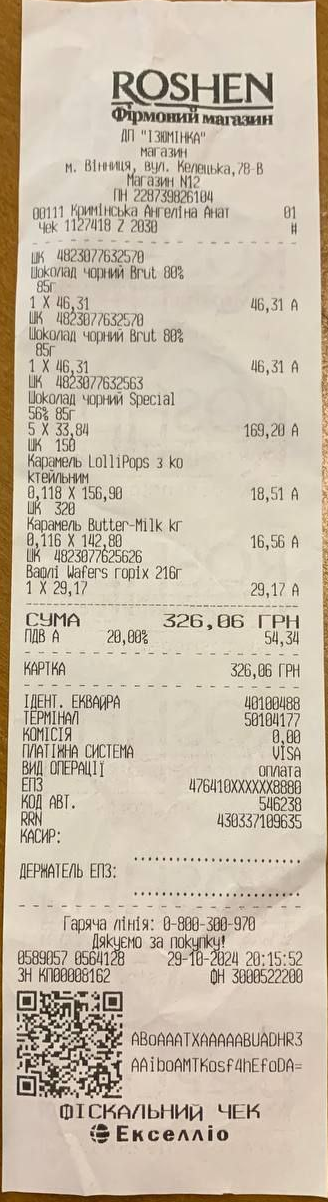

In [5]:
pipeline = PipelineModel(stages=[
    DataToImage(inputCol="content",
                outputCol="image"),
    YoloDetector(device=Device.CPU, 
                 keepInputData=True,
                 model="StabRise/receipt-detector-25-12-2024"),
    ImageCropBoxes(inputCols=["image", "boxes"],
                   outputCol="cropped_image"),
    DocTRTextDetector(inputCol="cropped_image",
                      outputCol="text_boxes",
                      device=Device.CPU,
                      keepInputData=True,
                      model="db_mobilenet_v3_large",
                      scoreThreshold=0.2),
    ImageDrawBoxes(keepInputData=True,
                   inputCols=["cropped_image", "text_boxes"],
                   filled=False,
                   color="green",
                   lineWidth=2,
                   displayDataList=['score']),
    TesseractRecognizer(inputCols=["cropped_image", "text_boxes"],
                        keepFormatting=True,
                        tessLib=TessLib.TESSEROCR.value,
                        scoreThreshold=0.1,
                        keepInputData=True,
                        scaleFactor=2,
                        lang=["ukr", "eng"])
])

result = pipeline.transform(df).cache()

result.show_image("cropped_image")


## Show Detected text

Image#:,0
Path:,receipt.jpg
Size:,328 x 1202 px
Resolution:,0 dpi

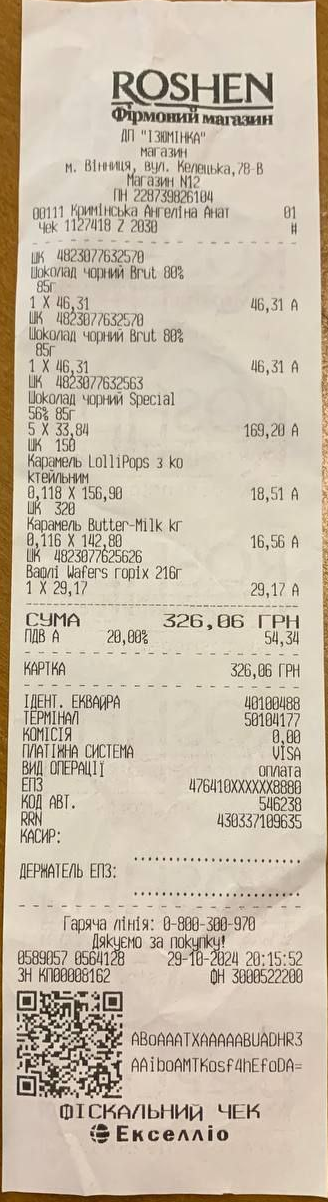

In [7]:
result.show_image("image_with_boxes")

## Show extracted text

In [9]:
result.show_text("text")

Id:,0
Path:,receipt.jpg
